# Dask pipeline

## Example: Tracking the International Space Station with Dask

In this notebook we will be using two APIs:

1. [Google Maps Geocoder](https://developers.google.com/maps/documentation/geocoding/overview)
2. [Open Notify API for ISS location](http://api.open-notify.org/)

We will use them to keep track of the ISS location and next lead time in relation to a list of cities. To create our diagrams and intelligently parallelise data, we use Dask, especially [Dask Delayed](https://docs.dask.org/en/latest/delayed.html).

### 1. Imports

In [1]:
import requests
import logging
import sys
import numpy as np
from time import sleep
from datetime import datetime
from math import radians
from dask import delayed
from operator import itemgetter
from sklearn.neighbors import DistanceMetric

### 2. Logger

In [2]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)

### 3. Latitude and longitude pairs from a list of cities

see also [Location APIs](https://locationiq.com/)

In [3]:
def get_lat_long(address):
    resp = requests.get(
        'https://eu1.locationiq.org/v1/search.php',
        params={'key': '92e7ba84cf3465',
                'q': address,
                'format': 'json'}
    )
    if resp.status_code != 200:
        print('There was a problem with your request!')
        print(resp.content)
        return
    data = resp.json()[0]
    return {
        'name': data.get('display_name'),
        'lat': float(data.get('lat')),
        'long': float(data.get('lon')),
    }

In [4]:
get_lat_long('Berlin, Germany')

{'name': 'Berlin, 10117, Germany', 'lat': 52.5170365, 'long': 13.3888599}

In [5]:
locations = []
for city in ['Seattle, Washington',
             'Miami, Florida', 
             'Berlin, Germany',
             'Singapore', 
             'Wellington, New Zealand',
             'Beirut, Lebanon',
             'Beijing, China',
             'Nairobi, Kenya',
             'Cape Town, South Africa',
             'Buenos Aires, Argentina']:
    locations.append(get_lat_long(city))
    sleep(2)

In [6]:
locations

[{'name': 'Seattle, King County, Washington, USA',
  'lat': 47.6038321,
  'long': -122.3300624},
 {'name': 'Miami, Miami-Dade County, Florida, USA',
  'lat': 25.7742658,
  'long': -80.1936589},
 {'name': 'Berlin, 10117, Germany', 'lat': 52.5170365, 'long': 13.3888599},
 {'name': 'Singapore, Singapore, Central, Singapore',
  'lat': 1.340863,
  'long': 103.830391822121},
 {'name': 'Wellington, Wellington City, Wellington, 6011, New Zealand',
  'lat': -41.2887953,
  'long': 174.7772114},
 {'name': 'Beirut, Ras Beirut, Beirut Governorate, Lebanon',
  'lat': 33.8959203,
  'long': 35.47843},
 {'name': 'Beijing, Dongcheng District, Beijing, 100010, China',
  'lat': 39.906217,
  'long': 116.3912757},
 {'name': 'Nairobi, Kenya', 'lat': -1.2832533, 'long': 36.8172449},
 {'name': 'Cape Town, City of Cape Town, Western Cape, 8001, South Africa',
  'lat': -33.928992,
  'long': 18.417396},
 {'name': 'Autonomous City of Buenos Aires, Comuna 6, Autonomous City of Buenos Aires, Argentina',
  'lat': -34

## 4. Retrieve ISS data and determine lead times for cities

In [7]:
def get_spaceship_location():
    resp = requests.get('http://api.open-notify.org/iss-now.json')
    location = resp.json()['iss_position']
    return {'lat': float(location.get('latitude')),
            'long': float(location.get('longitude'))}

In [8]:
def great_circle_dist(lon1, lat1, lon2, lat2):
    "Found on SO: http://stackoverflow.com/a/41858332/380442"
    dist = DistanceMetric.get_metric('haversine')
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    X = [[lat1, lon1], [lat2, lon2]]
    kms = 6367
    return (kms * dist.pairwise(X)).max()

In [9]:
def iss_dist_from_loc(issloc, loc):
    distance = great_circle_dist(issloc.get('long'), 
                                 issloc.get('lat'), 
                                 loc.get('long'), loc.get('lat'))
    logging.info('ISS is ~%dkm from %s', int(distance), loc.get('name'))
    return distance

In [10]:
def iss_pass_near_loc(loc):
    resp = requests.get('http://api.open-notify.org/iss-pass.json',
                        params={'lat': loc.get('lat'), 
                                'lon': loc.get('long')})
    data = resp.json().get('response')[0]
    td = datetime.fromtimestamp(data.get('risetime')) - datetime.now()
    m, s = divmod(int(td.total_seconds()), 60)
    h, m = divmod(m, 60)
    logging.info('ISS will pass near %s in %02d:%02d:%02d',loc.get('name'), h, m, s)
    return td.total_seconds()

In [11]:
iss_dist_from_loc(get_spaceship_location(), locations[4])

INFO:root:ISS is ~13325km from Wellington, Wellington City, Wellington, 6011, New Zealand


13325.326019595097

In [12]:
iss_pass_near_loc(locations[4])

INFO:root:ISS will pass near Wellington, Wellington City, Wellington, 6011, New Zealand in 02:32:28


9148.867879

## 5. Create a `delayed` pipeline

In [13]:
output = []

for loc in locations:
    issloc = delayed(get_spaceship_location)()
    dist = delayed(iss_dist_from_loc)(issloc, loc)
    output.append((loc.get('name'), dist))

closest = delayed(lambda x: sorted(x, 
                                   key=itemgetter(1))[0])(output)

In [14]:
closest

Delayed('lambda-7c277b48-05c2-46ec-b511-4b7740cf187d')

## 6. Show DAG

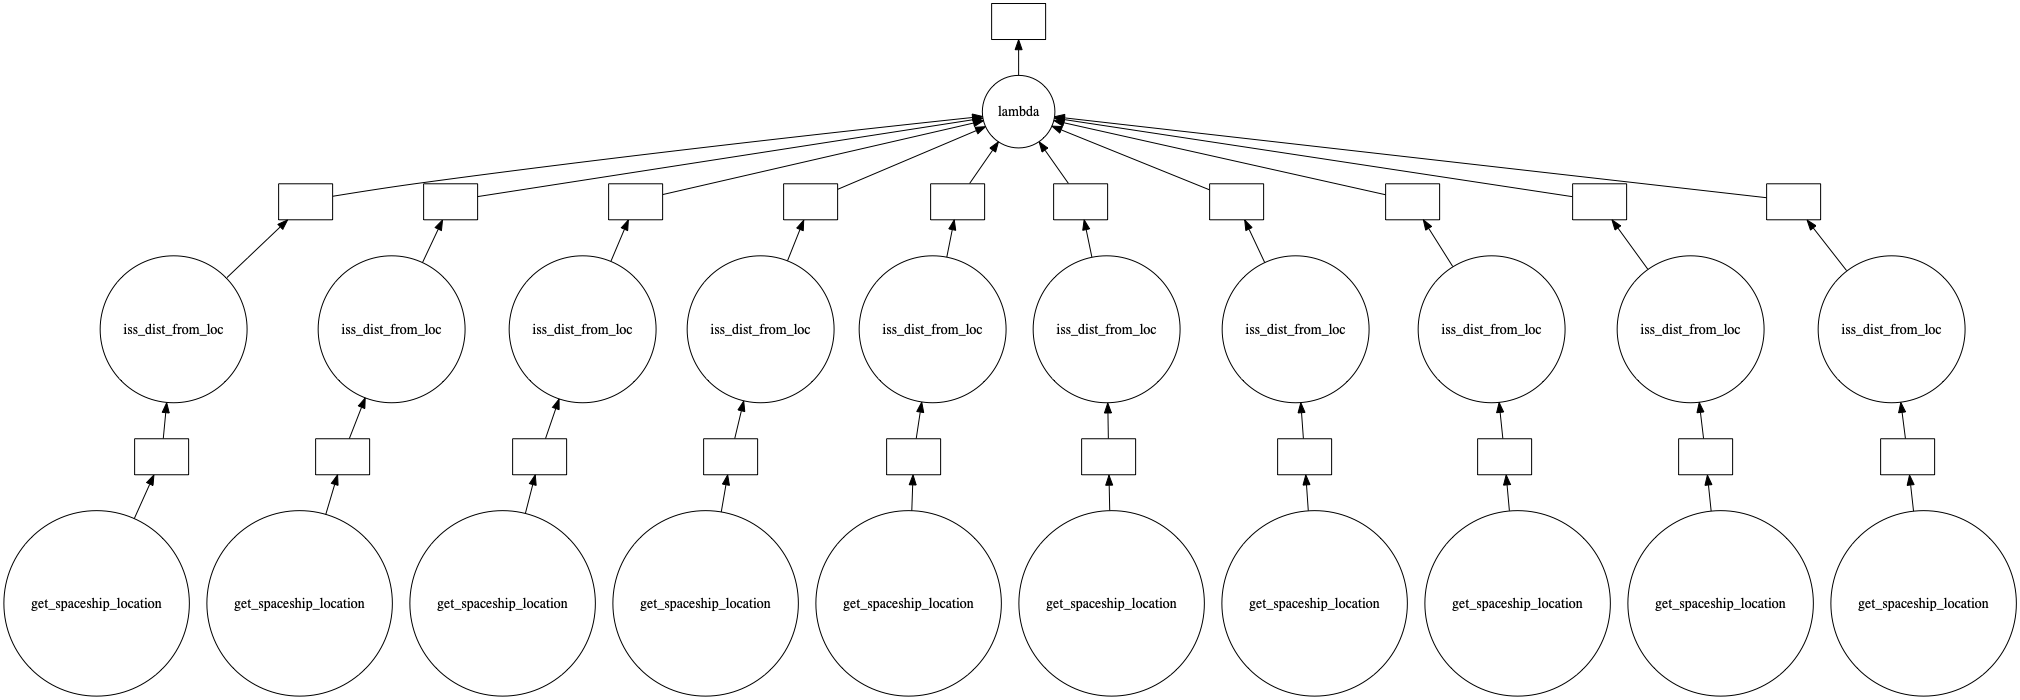

In [15]:
closest.visualize()

## 7. `compute()`

In [16]:
closest.compute()

INFO:root:ISS is ~8893km from Singapore, Singapore, Central, Singapore
INFO:root:ISS is ~9226km from Autonomous City of Buenos Aires, Comuna 6, Autonomous City of Buenos Aires, Argentina
INFO:root:ISS is ~14460km from Wellington, Wellington City, Wellington, 6011, New Zealand
INFO:root:ISS is ~3694km from Cape Town, City of Cape Town, Western Cape, 8001, South Africa
INFO:root:ISS is ~4071km from Beirut, Ras Beirut, Beirut Governorate, Lebanon
INFO:root:ISS is ~1443km from Nairobi, Kenya
INFO:root:ISS is ~13891km from Seattle, King County, Washington, USA
INFO:root:ISS is ~6033km from Berlin, 10117, Germany
INFO:root:ISS is ~11454km from Miami, Miami-Dade County, Florida, USA
INFO:root:ISS is ~10292km from Beijing, Dongcheng District, Beijing, 100010, China


('Nairobi, Kenya', 1443.4151385986981)